# Tool Performance Comparison on Simulated Data

This notebook analyzes tool-specific performance on simulated CRISPR spacer data using multi-metric distance validation. We focus on comparing individual tool performance using Hamming distance with threshold ≤5, leveraging multi-metric parquet files for efficient analysis.

## Key Focus Areas:
1. **Per-tool performance metrics** (precision, recall, F1)
2. **Tool-vs-tool comparisons** at different mismatch thresholds
3. **Performance characteristics** across different dataset sizes
4. **False positive and false negative analysis** per tool

This differs from distance_metric_analysis.ipynb which focuses on aggregate tool-independent metrics to compare Hamming vs Edit distance.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/')

import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
from bench.utils.functions import *
from bench.commands.compare_results import analyze_simulation_multi_metric
from lets_plot import *
import json

LetsPlot.setup_html()
pl.Config.set_tbl_cols(n=-1)

# Configuration - using Hamming distance with threshold 5 as specified
DISTANCE_METRIC = 'hamming'
MAX_THRESHOLD = 5
THRESHOLDS = list(range(0, MAX_THRESHOLD + 1))

# Load tool styles for consistent colors and markers
with open('notebooks/tool_styles.json', 'r') as f:
    TOOL_STYLES = json.load(f)

# Create color and shape mappings from tool styles for lets-plot
tool_colors = {tool: styles['color'] for tool, styles in TOOL_STYLES.items()}
tool_shapes = {tool: styles['letsplot_shape_num'] for tool, styles in TOOL_STYLES.items()}

print(f"Configuration: {DISTANCE_METRIC} distance, thresholds 0-{MAX_THRESHOLD}")
print(f"Loaded tool styles for {len(TOOL_STYLES)} tools")

Configuration: hamming distance, thresholds 0-5
Loaded tool styles for 11 tools


## Discover Simulations and Generate Multi-Metric Validation

First, we'll discover all simulation directories and generate multi-metric distance validation parquet files for each one (if they don't already exist).

In [2]:
def get_tools_run(sim_dir):
    """Detect which tools were actually run by checking for output files."""
    raw_outputs_dir = Path(sim_dir) / "raw_outputs"
    if not raw_outputs_dir.exists():
        return set()
    
    # Map output file patterns to tool names
    tool_patterns = {
        'blastn': 'blastn_output.tsv',
        'bowtie1': 'bowtie1_output.sam',
        'bowtie2': 'bowtie2_output.sam',
        'indelfree_bruteforce': 'indelfree_bruteforce_output.sam',
        'indelfree_indexed': 'indelfree_indexed_output.sam',
        'minimap2': 'minimap2_output.sam',
        'mmseqs2': 'mmseqs_output.tsv',
        'mummer4': 'mummer4_output.sam',
        'sassy': 'sassy.tsv',
        'strobealign': 'strobealign_output.sam',
        'x_mapper': 'x_mapper_output.sam',
    }
    
    tools_run = set()
    for tool, pattern in tool_patterns.items():
        if (raw_outputs_dir / pattern).exists():
            tools_run.add(tool)
    
    return tools_run

def format_num(n):
    """Format numbers for display (e.g., 100000 -> 100k)"""
    if n >= 1000000:
        return f"{n//1000000}M"
    elif n < 1000:
        return f"{n}"
    else:
        return f"{n//1000}k"

# Find all simulation directories
simulated_base_dir = "results/simulated"
simulation_dirs = sorted(glob.glob(os.path.join(simulated_base_dir, "ns_*")))

# Create simulation name mapping
SIMULATION_NAMES = {}
valid_sim_dirs = []

for sim_dir in simulation_dirs:
    sim_data_dir = Path(sim_dir) / "simulated_data"
    if not sim_data_dir.exists():
        continue
        
    prefix = os.path.basename(sim_dir)
    parts = prefix.split('_')
    
    if len(parts) >= 4:
        try:
            n_spacers = int(parts[1])
            n_contigs = int(parts[3])
            SIMULATION_NAMES[prefix] = f"{format_num(n_spacers)} spacers × {format_num(n_contigs)} contigs"
            valid_sim_dirs.append(sim_dir)
        except ValueError:
            # Keep as-is if can't parse
            SIMULATION_NAMES[prefix] = prefix
            valid_sim_dirs.append(sim_dir)

print(f"Found {len(SIMULATION_NAMES)} simulations:")
for prefix, desc in sorted(SIMULATION_NAMES.items()):
    print(f"  {prefix}: {desc}")

Found 8 simulations:
  ns_100000_nc_10000: 100k spacers × 10k contigs
  ns_100000_nc_20000: 100k spacers × 20k contigs
  ns_100_nc_50000: 100 spacers × 50k contigs
  ns_3826979_nc_421431_real_baseline: 3M spacers × 421k contigs
  ns_500000_nc_100000: 500k spacers × 100k contigs
  ns_50000_nc_5000: 50k spacers × 5k contigs
  ns_500_nc_5000_HIGH_INSERTION_RATE: 500 spacers × 5k contigs
  ns_75000_nc_5000: 75k spacers × 5k contigs


## Generate Multi-Metric Distance Files

Generate multi-metric validation parquet files for all simulations (checking if they already exist first).

In [4]:
# Generate multi-metric distance files for each simulation
for sim_dir in valid_sim_dirs:
    sim_name = os.path.basename(sim_dir)
    multi_metric_path = Path(sim_dir) / "multi_metric_distances.parquet"
    
    if multi_metric_path.exists():
        size_mb = multi_metric_path.stat().st_size / 1e6
        print(f"✓ {sim_name}: Multi-metric file exists ({size_mb:.2f} MB)")
        continue
    
    # Check if simulation has tool outputs
    tools_run = get_tools_run(sim_dir)
    if not tools_run:
        print(f"⚠ {sim_name}: No tool outputs found, skipping")
        continue
    
    print(f"\nGenerating multi-metric distances for {sim_name}...")
    print(f"  Tools run: {sorted(tools_run)}")
    
    # Get paths
    spacer_file = str(Path(sim_dir) / "simulated_data" / "simulated_spacers.fa")
    contig_file = str(Path(sim_dir) / "simulated_data" / "simulated_contigs.fa")
    ground_truth_file = str(Path(sim_dir) / "simulated_data" / "planned_ground_truth.tsv")
    
    # Validate files exist
    if not all(Path(f).exists() for f in [spacer_file, contig_file, ground_truth_file]):
        print("  ⚠ Missing required files, skipping")
        continue
    
    # Run multi-metric analysis
    try:
        multi_metric_results = analyze_simulation_multi_metric(
            sim_dir=str(sim_dir),
            max_distance_threshold=MAX_THRESHOLD,
            coordinate_tolerance=5,
            gap_open=5,
            gap_extend=5,
            spacer_file=spacer_file,
            contig_file=contig_file,
            ground_truth_file=ground_truth_file,
        )
        
        # Save results
        multi_metric_results.write_parquet(str(multi_metric_path))
        size_mb = multi_metric_path.stat().st_size / 1e6
        print(f"  ✓ Saved {multi_metric_results.height:,} alignments ({size_mb:.2f} MB)")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")
        continue

print("\n✓ Multi-metric generation complete")

✓ ns_100000_nc_10000: Multi-metric file exists (42.25 MB)
✓ ns_100000_nc_20000: Multi-metric file exists (60.98 MB)
⚠ ns_100_nc_50000: No tool outputs found, skipping
✓ ns_3826979_nc_421431_real_baseline: Multi-metric file exists (6.88 MB)

Generating multi-metric distances for ns_500000_nc_100000...
  Tools run: ['blastn', 'bowtie1', 'bowtie2', 'indelfree_indexed', 'minimap2', 'mmseqs2', 'mummer4', 'strobealign', 'x_mapper']
Loaded ground truth: 1498408 entries
Found 9 tools with results: ['blastn', 'bowtie1', 'bowtie2', 'indelfree_indexed', 'minimap2', 'mmseqs2', 'mummer4', 'strobealign', 'x_mapper']
Sample tool config:
  blastn: results/simulated/ns_500000_nc_100000/raw_outputs/blastn_output.tsv
Reading tool results...
Total alignments from all tools: 8338830
unique alignments from all tools: 2162819
Unique alignment regions: 2162819
Merged into 1584697 unique regions (with 5bp tolerance)
Loading sequences for distance calculations...
Calculating all distance metrics (hamming, edit,

## Select Primary Simulation for Detailed Analysis

Let's focus on one simulation for detailed tool comparison analysis.

In [5]:
# Select primary simulation - using the 100k spacers × 20k contigs as the main analysis
PRIMARY_SIM = "ns_100000_nc_20000"
primary_sim_dir = f"results/simulated/{PRIMARY_SIM}"

# Also analyze the high insertion rate simulation
HIGH_INS_SIM = "ns_500_nc_5000_HIGH_INSERTION_RATE"
high_ins_sim_dir = f"results/simulated/{HIGH_INS_SIM}"

# Load multi-metric data for primary simulation
primary_multi_metric_path = Path(primary_sim_dir) / "multi_metric_distances.parquet"

if primary_multi_metric_path.exists():
    primary_multi_metric = pl.read_parquet(primary_multi_metric_path)
    print(f"Loaded multi-metric data for {PRIMARY_SIM}")
    print(f"Shape: {primary_multi_metric.shape}")
    print(f"Columns: {primary_multi_metric.columns}")
    
    # Filter for hamming <= 5 and explode tools
    primary_results = primary_multi_metric.filter(
        pl.col('distance_hamming') <= MAX_THRESHOLD
    ).explode('tools').rename({'tools': 'tool'})
    
    tools_in_primary = sorted(primary_results['tool'].unique().to_list())
    print(f"\nTools found: {tools_in_primary}")
    print(f"Total alignments (long format): {primary_results.height:,}")
else:
    print(f"⚠ Multi-metric file not found: {primary_multi_metric_path}")
    primary_multi_metric = None
    primary_results = None

Loaded multi-metric data for ns_100000_nc_20000
Shape: (1446730, 17)
Columns: ['alignment_idx', 'region_idx', 'classification', 'tools', 'spacer_id', 'contig_id', 'start', 'end', 'strand', 'distance_hamming', 'distance_edit', 'distance_gap_affine', 'planned_mismatches', 'start_gt', 'end_gt', 'spacer_seq', 'contig_seq']

Tools found: ['blastn', 'bowtie1', 'bowtie2', 'indelfree_bruteforce', 'indelfree_indexed', 'minimap2', 'mmseqs2', 'mummer4', 'sassy', 'strobealign', 'x_mapper']
Total alignments (long format): 3,010,345


## REMINDER:
The ns_100000_nc_20000 was called with:
```bash 
# 100_000 spacers, 20_000 contigs, 1-5 insertions, 25-40 spacer length, 10000-150000 contig length, 0-5 mismatches
pixi run "spacer_bencher simulate --contig-distribution normal  --spacer-distribution normal --num-spacers 100000 --gc-content 49 --spacer-insertions 1 5 --num-contigs 20000 --spacer-length 25 40  --contig-length 10000 150000 --mismatch-range 0 3 --output-dir ../results/simulated/ns_100000_nc_20000/ --threads 8"
```
So:
- 100,000 spacers
- 20,000 contigs
- 1-5 insertions per spacer
- Spacer length 25-40 bp
- Contig length 10,000-150,000 bp
- Mismatches 0-3 (Hamming distance thresholds)
- GC content 49% (both spacers and contigs)
- Normal distributions for lengths.

This means that all alignments with >3 mismatches are non-planned (but still validated), so they would be considerably rarer than those 0-3 mismatches. Hence, the cumulative performance above >3 mismatches is the not very representative, as they "engulf" the results of the very common 0-3 mismatch alignments. for that range (>3) The more informative would be the "exact" plot (recall for tool when only considering alignments with exactly that many mismatches).

In [6]:
# Calculate recall metrics for primary simulation at threshold=3
if primary_results is not None:
    # Calculate per-tool metrics at hamming <= 3
    threshold = 3
    
    # Get total unique regions at this threshold using region_idx
    total_regions = primary_results.filter(
        pl.col('distance_hamming') <= threshold
    ).select('region_idx').unique().height
    
    perf_metrics = []
    
    for tool in tools_in_primary:
        # Count unique regions detected by this tool
        tool_regions = primary_results.filter(
            (pl.col('tool') == tool) &
            (pl.col('distance_hamming') <= threshold)
        ).select('region_idx').unique().height
        
        # Calculate recall
        recall = tool_regions / total_regions if total_regions > 0 else 0
        
        perf_metrics.append({
            'tool': tool,
            'n_regions': tool_regions,
            'total_regions': total_regions,
            'recall': recall,
        })
    
    perf_df = pl.DataFrame(perf_metrics).sort('recall', descending=True)
    
    print(f"Performance metrics at Hamming ≤ {threshold}:")
    print(perf_df)

Performance metrics at Hamming ≤ 3:
shape: (11, 4)
┌──────────────────────┬───────────┬───────────────┬──────────┐
│ tool                 ┆ n_regions ┆ total_regions ┆ recall   │
│ ---                  ┆ ---       ┆ ---           ┆ ---      │
│ str                  ┆ i64       ┆ i64           ┆ f64      │
╞══════════════════════╪═══════════╪═══════════════╪══════════╡
│ bowtie1              ┆ 300248    ┆ 300248        ┆ 1.0      │
│ indelfree_bruteforce ┆ 300248    ┆ 300248        ┆ 1.0      │
│ indelfree_indexed    ┆ 300248    ┆ 300248        ┆ 1.0      │
│ sassy                ┆ 295125    ┆ 300248        ┆ 0.982937 │
│ bowtie2              ┆ 293163    ┆ 300248        ┆ 0.976403 │
│ blastn               ┆ 233405    ┆ 300248        ┆ 0.777374 │
│ mmseqs2              ┆ 216173    ┆ 300248        ┆ 0.719981 │
│ strobealign          ┆ 164494    ┆ 300248        ┆ 0.54786  │
│ mummer4              ┆ 152336    ┆ 300248        ┆ 0.507367 │
│ x_mapper             ┆ 123983    ┆ 300248        ┆ 

## Tool Recall at Different Hamming Distance Thresholds

Load all thresholds for the primary simulation to see how each tool performs when allowing up to N mismatches. This reveals which tools cannot perform above certain distance thresholds.

In [7]:
# Calculate performance for all thresholds (cumulative)
if primary_results is not None:
    cumulative_performance = []
    exact_performance = []
    
    for threshold in THRESHOLDS:
        # Get total unique regions at this threshold (cumulative)
        total_regions_cumulative = primary_results.filter(
            pl.col('distance_hamming') <= threshold
        ).select('region_idx').unique().height
        
        # Get total unique regions at exact distance
        total_regions_exact = primary_results.filter(
            pl.col('distance_hamming') == threshold
        ).select('region_idx').unique().height
        
        for tool in tools_in_primary:
            # CUMULATIVE (≤)
            tool_regions_cumulative = primary_results.filter(
                (pl.col('distance_hamming') <= threshold) &
                (pl.col('tool') == tool)
            ).select('region_idx').unique().height
            
            recall_cumulative = tool_regions_cumulative / total_regions_cumulative if total_regions_cumulative > 0 else 0
            
            cumulative_performance.append({
                'threshold': threshold,
                'tool': tool,
                'recall': recall_cumulative,
                'n_regions': tool_regions_cumulative,
                'total_regions': total_regions_cumulative,
            })
            
            # EXACT (==)
            tool_regions_exact = primary_results.filter(
                (pl.col('distance_hamming') == threshold) &
                (pl.col('tool') == tool)
            ).select('region_idx').unique().height
            
            recall_exact = tool_regions_exact / total_regions_exact if total_regions_exact > 0 else 0
            
            exact_performance.append({
                'threshold': threshold,
                'tool': tool,
                'recall': recall_exact,
                'n_regions': tool_regions_exact,
                'total_regions': total_regions_exact,
            })
    
    cumulative_perf = pl.DataFrame(cumulative_performance)
    exact_perf = pl.DataFrame(exact_performance)
    
    print(f"Cumulative performance shape: {cumulative_perf.shape}")
    print(f"Exact performance shape: {exact_perf.shape}")

Cumulative performance shape: (66, 5)
Exact performance shape: (66, 5)


## Visualize Tool Recall at max and exact Hamming Distances

Using tool-specific colors and markers from tool_styles.json

In [12]:
# Create cumulative recall plot
cumulative_dict = cumulative_perf.select(['tool', 'threshold', 'recall']).to_dict(as_series=False)

chart_cumulative = (
    ggplot(cumulative_dict, aes(x='threshold', y='recall', color='tool', group='tool')) +
    geom_line(size=1.5) +
    geom_point(aes(shape='tool'), size=4) +
    scale_color_manual(values=tool_colors, name='Tool') +
    scale_shape_manual(values=tool_shapes, name='Tool') +
    scale_y_continuous(limits=[0, 1.05]) +
    labs(
        x='Hamming Distance Threshold (cumulative, ≤)',
        y='Recall (tool-detected / all valid alignments)',
        title=f'Tool Recall vs Maximum Hamming Distance Threshold ({PRIMARY_SIM})'
    ) +
    ggsize(1000, 600) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        legend_position='right'
    )
)

# Create exact recall plot
exact_dict = exact_perf.select(['tool', 'threshold', 'recall']).to_dict(as_series=False)

chart_exact = (
    ggplot(exact_dict, aes(x='threshold', y='recall', color='tool', group='tool')) +
    geom_line(size=1.5) +
    geom_point(aes(shape='tool'), size=4) +
    scale_color_manual(values=tool_colors, name='Tool') +
    scale_shape_manual(values=tool_shapes, name='Tool') +
    scale_y_continuous(limits=[0, 1.05]) +
    labs(
        x='Hamming Distance (exactly x)',
        y='Recall (tool-detected / all valid alignments)',
        title=f'Tool Recall at Exact Hamming Distance ({PRIMARY_SIM})'
    ) +
    ggsize(1000, 600) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        legend_position='right'
    )
)

# Save visualizations
output_dir = f"{primary_sim_dir}/plots"
os.makedirs(output_dir, exist_ok=True)

chart_cumulative.to_html(f'{output_dir}/tool_recall_cumulative_hamming.html')
chart_cumulative.to_svg(f'{output_dir}/tool_recall_cumulative_hamming.svg')
chart_exact.to_html(f'{output_dir}/tool_recall_exact_hamming.html')
chart_exact.to_svg(f'{output_dir}/tool_recall_exact_hamming.svg')

print(f"Saved visualizations to {output_dir}/")

# Display both charts side by side
gggrid([chart_cumulative, chart_exact], ncol=2,fit=True,guides='collect')

Saved visualizations to results/simulated/ns_100000_nc_20000/plots/


### **Note!**
For sassy, the "exact" plot above is not too useful - it is usually able to identify these regions (>3 mismatches) but at a lower distance (as it does edit), and when subsetting the recall values to "exact", sassy alignments won't show up as many of them are listed different distances. Hence for that, the cumulative plot might be more informative - HOWEVER ! note the "crash" for bowtie1 and bowtie2 for >3 mismatches - bowtie1 limit - which can not be made out from the cumulative plot...

## High Insertion Rate Simulation Analysis

Some tools struggle with spacers that have high occurrence rates. Let's analyze the HIGH_INSERTION_RATE simulation to test this.

### Recall vs Number of Occurrences Analysis (HIGH_INSERTION_RATE)

The HIGH_INSERTION_RATE simulation is specifically designed to test how tools perform with spacers that have many occurrences in the reference. Let's analyze whether recall drops as the number of occurrences increases.

In [15]:
# Load high insertion rate simulation multi-metric data
high_ins_multi_metric_path = Path(high_ins_sim_dir) / "multi_metric_distances.parquet"

high_ins_multi_metric = pl.read_parquet(high_ins_multi_metric_path)
print(f"Loaded multi-metric data for {HIGH_INS_SIM}")
print(f"Shape: {high_ins_multi_metric.shape}")

# Filter and explode
high_ins_results = high_ins_multi_metric.filter(
    pl.col('distance_hamming') <= MAX_THRESHOLD
).explode('tools').rename({'tools': 'tool'})

high_ins_tools = sorted(high_ins_results['tool'].unique().to_list())
print(f"Tools: {high_ins_tools}")

# Calculate cumulative and exact performance
high_ins_cumulative = []
high_ins_exact = []

for threshold in THRESHOLDS:
    total_regions_cumulative = high_ins_results.filter(
        pl.col('distance_hamming') <= threshold
    ).select('region_idx').unique().height
    
    total_regions_exact = high_ins_results.filter(
        pl.col('distance_hamming') == threshold
    ).select('region_idx').unique().height
    
    for tool in high_ins_tools:
        # Cumulative
        tool_regions_cumulative = high_ins_results.filter(
            (pl.col('distance_hamming') <= threshold) &
            (pl.col('tool') == tool)
        ).select('region_idx').unique().height
        
        high_ins_cumulative.append({
            'threshold': threshold,
            'tool': tool,
            'recall': tool_regions_cumulative / total_regions_cumulative if total_regions_cumulative > 0 else 0,
        })
        
        # Exact
        tool_regions_exact = high_ins_results.filter(
            (pl.col('distance_hamming') == threshold) &
            (pl.col('tool') == tool)
        ).select('region_idx').unique().height
        
        high_ins_exact.append({
            'threshold': threshold,
            'tool': tool,
            'recall': tool_regions_exact / total_regions_exact if total_regions_exact > 0 else 0,
        })

high_ins_cumulative_perf = pl.DataFrame(high_ins_cumulative)
high_ins_exact_perf = pl.DataFrame(high_ins_exact)

print(f"High insertion cumulative performance: {high_ins_cumulative_perf.shape}")
print(f"High insertion exact performance: {high_ins_exact_perf.shape}")

Loaded multi-metric data for ns_500_nc_5000_HIGH_INSERTION_RATE
Shape: (861798, 17)
Tools: ['blastn', 'bowtie1', 'bowtie2', 'indelfree_bruteforce', 'indelfree_indexed', 'mmseqs2', 'mummer4', 'sassy', 'strobealign', 'x_mapper']
High insertion cumulative performance: (60, 3)
High insertion exact performance: (60, 3)


In [18]:
# Plot recall for high insertion rate simulation
high_ins_cumulative_dict = high_ins_cumulative_perf.select(['tool', 'threshold', 'recall']).to_dict(as_series=False)
high_ins_exact_dict = high_ins_exact_perf.select(['tool', 'threshold', 'recall']).to_dict(as_series=False)

high_ins_chart_cumulative = (
    ggplot(high_ins_cumulative_dict, aes(x='threshold', y='recall', color='tool', group='tool')) +
    geom_line(size=1.5) +
    geom_point(aes(shape='tool'), size=4) +
    scale_color_manual(values=tool_colors, name='Tool') +
    scale_shape_manual(values=tool_shapes, name='Tool') +
    scale_y_continuous(limits=[0, 1.05]) +
    labs(
        x='Hamming Distance Threshold (≤)',
        y='Recall (Augmented)',
        title=f'Tool Recall vs Hamming Distance Threshold - Cumulative ({HIGH_INS_SIM})'
    ) +
    ggsize(1000, 600) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        legend_position='right'
    )
)

high_ins_chart_exact = (
    ggplot(high_ins_exact_dict, aes(x='threshold', y='recall', color='tool', group='tool')) +
    geom_line(size=1.5) +
    geom_point(aes(shape='tool'), size=4) +
    scale_color_manual(values=tool_colors, name='Tool') +
    scale_shape_manual(values=tool_shapes, name='Tool') +
    scale_y_continuous(limits=[0, 1.05]) +
    labs(
        x='Hamming Distance (==)',
        y='Recall (Augmented)',
        title=f'Tool Recall at Exact Hamming Distance ({HIGH_INS_SIM})'
    ) +
    ggsize(1000, 600) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        legend_position='right'
    )
)

# Save visualizations
high_ins_output_dir = f"{high_ins_sim_dir}/plots"
os.makedirs(high_ins_output_dir, exist_ok=True)

high_ins_chart_cumulative.to_html(f'{high_ins_output_dir}/tool_recall_cumulative_hamming.html')
high_ins_chart_cumulative.to_svg(f'{high_ins_output_dir}/tool_recall_cumulative_hamming.svg')
high_ins_chart_exact.to_html(f'{high_ins_output_dir}/tool_recall_exact_hamming.html')
high_ins_chart_exact.to_svg(f'{high_ins_output_dir}/tool_recall_exact_hamming.svg')

print(f"Saved high insertion rate visualizations to {high_ins_output_dir}/")

# Display both charts
gggrid([high_ins_chart_cumulative, high_ins_chart_exact], ncol=2)

Saved high insertion rate visualizations to results/simulated/ns_500_nc_5000_HIGH_INSERTION_RATE/plots/


In [19]:
import matplotlib.pyplot as plt

def create_spacer_counts_with_tools(results_df, tools_list, mismatches=3, exact_or_max="exact"):
    """
    Create spacer occurrence counts with tool detection fractions.
    
    Args:
        results_df: DataFrame with tool results
        tools_list: List of tool names
        mismatches: Mismatch threshold
        exact_or_max: "exact" for exact mismatches, "max" for ≤ mismatches
    
    Returns:
        DataFrame with spacer_id, n_occurrences, and columns for each tool showing detection fraction
    """
    # First get total occurrences per spacer across all tools
    if exact_or_max == "max":
        spacer_counts = results_df.filter(pl.col('distance_hamming') <= mismatches)
    else:
        spacer_counts = results_df.filter(pl.col('distance_hamming') == mismatches)
    
    spacer_counts = spacer_counts.select(["spacer_id", "contig_id"])\
        .unique()\
        .group_by('spacer_id')\
        .agg(pl.count('contig_id').alias('n_occurrences'))

    # Calculate matches per tool and spacer
    if exact_or_max == "max":
        tool_matches = results_df.filter(pl.col('distance_hamming') <= mismatches)
    else:
        tool_matches = results_df.filter(pl.col('distance_hamming') == mismatches)
    
    tool_matches = tool_matches.select(['spacer_id', 'tool', 'contig_id'])\
        .unique()\
        .group_by(['spacer_id', 'tool'])\
        .agg(pl.count('contig_id').alias('tool_matches'))

    # Create a cross join of all spacers with all tools
    all_combinations = spacer_counts.select('spacer_id', 'n_occurrences')\
        .join(
            pl.DataFrame({'tool': tools_list}),
            how='cross'
        )

    # Join the actual matches and calculate fractions
    complete_fractions = all_combinations\
        .join(
            tool_matches,
            on=['spacer_id', 'tool'],
            how='left'
        )\
        .with_columns([
            pl.col('tool_matches').fill_null(0),
            (pl.col('tool_matches') / pl.col('n_occurrences')).alias('fraction')
        ])

    # Pivot to get tools as columns
    spacer_counts_with_tools = complete_fractions\
        .pivot(
            index=['spacer_id', 'n_occurrences'],
            on='tool',
            values='fraction'
        )\
        .fill_null(0)
    
    return spacer_counts_with_tools


def plot_combined_recall_vs_occurrences(results_df, tools_list, n_high_occ_bins=3, 
                         output_prefix='results/simulated/recall_vs_occurrences', 
                         max_bin=3, n_bins=150, color_dict=None, marker_dict=None, exact_or_max="exact",
                         plot_mismatches=[1,3]):
    """
    Plot recall vs number of occurrences for different mismatch thresholds.
    """
    
    # Create color and marker dictionaries for consistent styling
    if color_dict is None:
        color_dict = tool_colors
    if marker_dict is None:
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', '+', 'x']
        marker_dict = {tool: markers[i % len(markers)] for i, tool in enumerate(tools_list)}

    # Create figure with subplots
    fig, axes = plt.subplots(len(plot_mismatches), 1, figsize=(15, 10 * len(plot_mismatches)))
    if len(plot_mismatches) == 1:
        axes = [axes]
    
    for i, mismatches in enumerate(plot_mismatches):
        # Create a new figure for the single plot
        fig_single, ax_single = plt.subplots(figsize=(15, 10))
        
        # Plot on both the combined and single figures
        plot_on_axis(axes[i], results_df, tools_list, n_high_occ_bins, n_bins, max_bin, 
                    mismatches=mismatches, exact_or_max=exact_or_max, color_dict=color_dict, 
                    marker_dict=marker_dict, output_prefix=output_prefix)
        plot_on_axis(ax_single, results_df, tools_list, n_high_occ_bins, n_bins, max_bin, 
                    mismatches=mismatches, exact_or_max=exact_or_max, color_dict=color_dict, 
                    marker_dict=marker_dict, output_prefix=output_prefix)
        
        # Set titles
        if exact_or_max == "exact":
            title = f'Recall vs number of occurrences (mismatches == {mismatches})'
        else:
            title = f'Recall vs number of occurrences (mismatches ≤ {mismatches})'
        axes[i].set_title(title, fontsize=14, fontweight='bold')
        ax_single.set_title(title, fontsize=14, fontweight='bold')
        
        # Save single plot
        plt.figure(fig_single.number)
        plt.tight_layout()
        fig_single.savefig(f'{output_prefix}_{exact_or_max}_mm_{mismatches}.pdf', bbox_inches='tight', format='pdf')
        fig_single.savefig(f'{output_prefix}_{exact_or_max}_mm_{mismatches}.png', bbox_inches='tight', format='png', dpi=150)
        plt.close(fig_single)
    
    # Save combined plot
    plt.figure(fig.number)
    plt.tight_layout()
    plot_mismatches_str = "_".join([str(d) for d in plot_mismatches])
    fig.savefig(f'{output_prefix}_{exact_or_max}_mm_{plot_mismatches_str}_combined.pdf', bbox_inches='tight')
    fig.savefig(f'{output_prefix}_{exact_or_max}_mm_{plot_mismatches_str}_combined.png', bbox_inches='tight', dpi=150)
    plt.show()


def plot_on_axis(ax: plt.Axes, results_df, tools_list, n_high_occ_bins, n_bins, max_bin, 
                 mismatches, exact_or_max, color_dict, marker_dict, output_prefix):
    """Helper function to plot on a given axis."""
    
    spacer_counts_with_tools = create_spacer_counts_with_tools(results_df, tools_list, 
                                                             mismatches=mismatches, 
                                                             exact_or_max=exact_or_max)

    # Create range bins for number of occurrences
    bins = np.logspace(np.log10(1), max_bin, n_bins)

    # Calculate mean fraction for each tool within each bin
    bin_stats = []
    for i in range(len(bins)-1):
        mask = (spacer_counts_with_tools['n_occurrences'] >= bins[i]) & \
               (spacer_counts_with_tools['n_occurrences'] < bins[i+1])
        bin_data = spacer_counts_with_tools.filter(mask)
        if bin_data.height > 0:
            stats = {
                'bin_start': bins[i],
                'bin_end': bins[i+1],
                'n_spacers': bin_data.height
            }
            for tool in tools_list:
                if tool in bin_data.columns:
                    stats[tool] = bin_data[tool].mean()
                else:
                    stats[tool] = 0.0
            bin_stats.append(stats)

    # Add points for high occurrences in multiple bins
    if n_high_occ_bins > 0:
        high_occ_edges = np.logspace(3, 4, n_high_occ_bins + 1)
        for i in range(n_high_occ_bins):
            bin_start = high_occ_edges[i]
            bin_end = high_occ_edges[i + 1]
            
            if i == n_high_occ_bins - 1:
                high_occ_mask = (spacer_counts_with_tools['n_occurrences'] >= bin_start)
            else:
                high_occ_mask = (spacer_counts_with_tools['n_occurrences'] >= bin_start) & \
                               (spacer_counts_with_tools['n_occurrences'] < bin_end)
            
            high_occ_data = spacer_counts_with_tools.filter(high_occ_mask)
            if high_occ_data.height > 0:
                high_occ_stats = {
                    'bin_start': bin_start,
                    'bin_end': bin_end,
                    'n_spacers': high_occ_data.height
                }
                for tool in tools_list:
                    if tool in high_occ_data.columns:
                        high_occ_stats[tool] = high_occ_data[tool].mean()
                    else:
                        high_occ_stats[tool] = 0.0
                bin_stats.append(high_occ_stats)

    # Plot on the provided axis
    for tool in tools_list:
        x = [(stat['bin_start'] + stat['bin_end'])/2 for stat in bin_stats]
        y = [stat[tool] for stat in bin_stats]
        ax.plot(x, y, label=tool, markersize=6, linewidth=2, 
                color=color_dict.get(tool, '#000000'), 
                markerfacecolor=color_dict.get(tool, '#000000'),
                marker=marker_dict.get(tool, 'o'))

    ax.set_xscale('log')
    ax.set_xlabel('Number of occurrences (log scale)', fontsize=12)
    ax.set_ylabel('Mean Detection Fraction', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.grid(True, which="major", ls="-", alpha=0.5)
    ax.minorticks_on()
    ax.set_ylim(0, 1.05)
    ax.set_xlim(1, 10**4)

Tools in HIGH_INSERTION_RATE: ['blastn', 'bowtie1', 'bowtie2', 'indelfree_bruteforce', 'indelfree_indexed', 'mmseqs2', 'mummer4', 'sassy', 'strobealign', 'x_mapper']


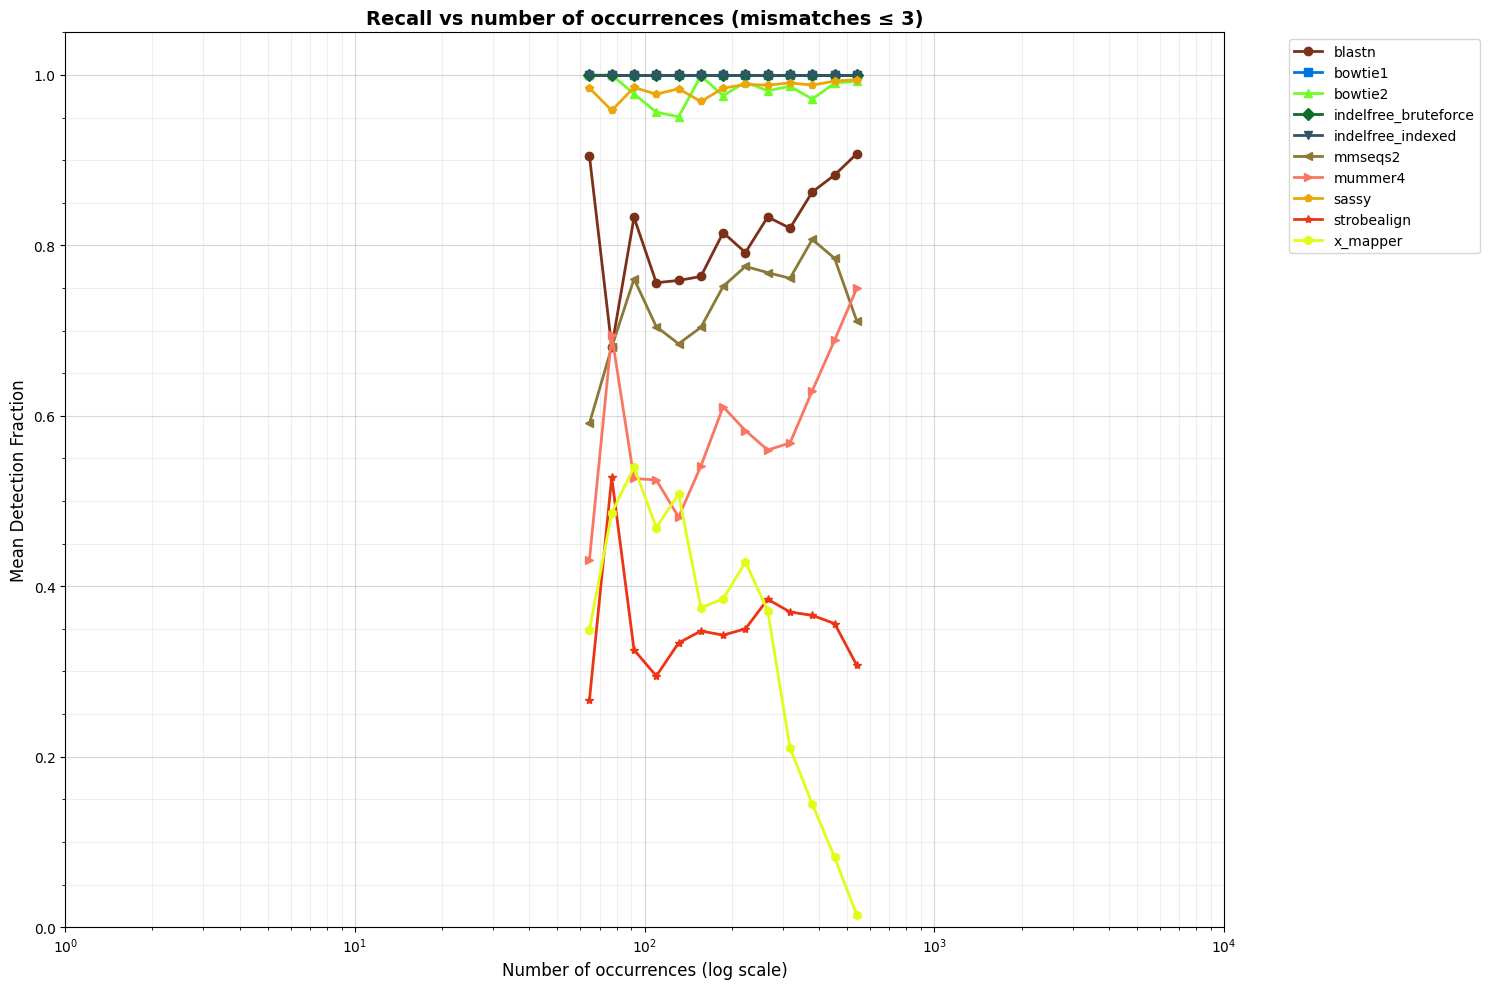

✓ Saved recall vs occurrences plots to: results/simulated/ns_500_nc_5000_HIGH_INSERTION_RATE/plots


In [20]:
# Create recall vs occurrences plots for HIGH_INSERTION_RATE simulation
if high_ins_results is not None:
    print(f"Tools in HIGH_INSERTION_RATE: {high_ins_tools}")
    
    # Create output directory
    high_ins_occ_output_dir = f"{high_ins_sim_dir}/plots"
    os.makedirs(high_ins_occ_output_dir, exist_ok=True)
    
    # Plot for mismatches ≤ 3
    plot_combined_recall_vs_occurrences(
        results_df=high_ins_results,
        tools_list=high_ins_tools,
        n_high_occ_bins=3,
        output_prefix=f'{high_ins_occ_output_dir}/recall_vs_occurrences',
        max_bin=3,
        n_bins=40,
        color_dict=tool_colors,
        exact_or_max="max",
        plot_mismatches=[3]
    )
    
    print(f"✓ Saved recall vs occurrences plots to: {high_ins_occ_output_dir}")

**Analysis of Results**: The plot above shows how each tool's detection rate (recall) varies as a function of the number of times a spacer appears in the reference contigs. A downward slope indicates that the tool struggles more as the number of occurrences increases, which is expected for the HIGH_INSERTION_RATE simulation that specifically tests this scenario.

## Tool Recall Rankings Across Multiple Simulations

Compare how tools rank across different simulation sizes based on recall (augmented).

In [21]:
# Load threshold=3 results from all simulations
all_sims_data = []

# Exclude the real baseline
exclude_sims = ['ns_3826979_nc_421431_real_baseline', 'ns_100_nc_50000']

for sim_prefix in SIMULATION_NAMES.keys():
    if sim_prefix in exclude_sims:
        continue
        
    sim_dir = f"results/simulated/{sim_prefix}"
    multi_metric_path = Path(sim_dir) / "multi_metric_distances.parquet"
    
    if not multi_metric_path.exists():
        print(f"⚠ Skipping {sim_prefix}: no multi-metric file")
        continue
    
    print(f"Loading {sim_prefix}...")
    
    # Load and process
    sim_multi_metric = pl.read_parquet(multi_metric_path)
    sim_results = sim_multi_metric.filter(
        pl.col('distance_hamming') <= 3
    ).explode('tools').rename({'tools': 'tool'})
    
    # Calculate recall for each tool using region_idx
    total_regions = sim_results.filter(
        pl.col('distance_hamming') <= 3
    ).select('region_idx').unique().height
    
    for tool in sim_results['tool'].unique().to_list():
        tool_regions = sim_results.filter(
            (pl.col('tool') == tool) &
            (pl.col('distance_hamming') <= 3)
        ).select('region_idx').unique().height
        
        recall = tool_regions / total_regions if total_regions > 0 else 0
        
        all_sims_data.append({
            'simulation': sim_prefix,
            'sim_description': SIMULATION_NAMES[sim_prefix],
            'tool': tool,
            'recall': recall,
            'n_regions': tool_regions,
        })

all_sims_combined = pl.DataFrame(all_sims_data)

print(f"\nLoaded data from {all_sims_combined['simulation'].n_unique()} simulations")
print(f"Total rows: {all_sims_combined.shape[0]}")
print(f"Simulations: {sorted(all_sims_combined['simulation'].unique().to_list())}")

Loading ns_100000_nc_10000...
Loading ns_100000_nc_20000...
Loading ns_500000_nc_100000...
Loading ns_50000_nc_5000...
Loading ns_500_nc_5000_HIGH_INSERTION_RATE...
Loading ns_75000_nc_5000...

Loaded data from 6 simulations
Total rows: 62
Simulations: ['ns_100000_nc_10000', 'ns_100000_nc_20000', 'ns_500000_nc_100000', 'ns_50000_nc_5000', 'ns_500_nc_5000_HIGH_INSERTION_RATE', 'ns_75000_nc_5000']


# Pivot table showing recall across simulations

In [23]:
# Create recall heatmap across all simulations
heatmap_df = all_sims_combined.select(['tool', 'simulation', 'recall'])
heatmap_df = heatmap_df.with_columns(
    pl.col('recall').round(2).cast(pl.Utf8).alias('label')
)

recall_heatmap = (
    ggplot(heatmap_df, aes(x='simulation', y='tool', fill='recall')) +
    geom_tile(color='white', size=0.5) +
    geom_text(aes(label='label'), color='white', size=6, fontface='bold') +
    scale_fill_gradient(low='#440154', high='#FDE724', limits=[0, 1], name='Recall\n(Augmented)') +
    labs(
        x='Simulation',
        y='Tool',
        title='Tool Recall Across Simulations (Hamming Distance ≤ 3)'
    ) +
    ggsize(900, 600) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        axis_text_x=element_text(angle=45, hjust=1)
    )
)

# Save mean recall visualization
mean_recall_output_dir = f"{simulated_base_dir}/plots"
os.makedirs(mean_recall_output_dir, exist_ok=True)
recall_heatmap.to_html(f"{mean_recall_output_dir}/tool_recall_heatmap_hamming3.html")
recall_heatmap.to_svg(f"{mean_recall_output_dir}/tool_recall_heatmap_hamming3.svg")

recall_heatmap

## Tool Recall Summary Statistics

Calculate mean recall across all simulations to identify best performers.

In [24]:
# Calculate mean and std recall across simulations
tool_summary = all_sims_combined.group_by('tool').agg([
    pl.col('recall').mean().alias('mean_recall'),
    pl.col('recall').std().alias('std_recall'),
    pl.col('n_regions').sum().alias('total_regions'),
]).sort('mean_recall', descending=True)

tool_summary

tool,mean_recall,std_recall,total_regions
str,f64,f64,i64
"""indelfree_bruteforce""",1.0,0.0,1169619
"""bowtie1""",1.0,0.0,2683173
"""indelfree_indexed""",1.0,0.0,2683173
"""sassy""",0.98316,0.000494,1149762
"""bowtie2""",0.975776,0.002773,2611195
"""blastn""",0.776559,0.002166,2078677
"""mmseqs2""",0.68562,0.077289,1821214
"""mummer4""",0.509958,0.006956,1362078
"""strobealign""",0.474056,0.167279,1037842


In [25]:
# Visualize mean recall with error bars
error_bar_data = all_sims_combined.group_by('tool').agg([
    pl.col('recall').mean().alias('mean_recall'),
    pl.col('recall').std().alias('std_recall'),
    (pl.col('recall').mean() + pl.col('recall').std()).alias("std_max"),
    (pl.col('recall').mean() - pl.col('recall').std()).alias("std_min")
])

error_bar_data = error_bar_data.with_columns(
    pl.when(pl.col('std_min') < 0).then(pl.lit(0)).otherwise(pl.col('std_min')).alias('std_min'),
    pl.when(pl.col('std_max') > 1).then(pl.lit(1)).otherwise(pl.col('std_max')).alias('std_max')
)

# Create error bar chart with points
chart = (
    ggplot(error_bar_data, aes(x='tool', y='mean_recall')) +
    geom_errorbar(aes(ymin="std_min", ymax="std_max"), width=0.2) +
    geom_point(aes(color='tool'), size=4, shape=19) +
    scale_color_manual(values=tool_colors) +
    scale_y_continuous(limits=[0, 1.05]) +
    labs(
        x='Tool',
        y='Recall (mean ± std dev)',
        title='Mean Recall ± Std Dev Across Simulations (Hamming Distance ≤ 3)'
    ) +
    ggsize(700, 400) +
    theme_minimal() +
    theme(      
        plot_title=element_text(size=14, face='bold'),
        axis_text_x=element_text(angle=45, hjust=1),
        legend_position='none'
    )
)

# Save mean recall visualization
mean_recall_output_dir = f"{simulated_base_dir}/plots"
os.makedirs(mean_recall_output_dir, exist_ok=True)
chart.to_html(f"{mean_recall_output_dir}/mean_recall_error_bars.html")
chart.to_svg(f"{mean_recall_output_dir}/mean_recall_error_bars.svg")

print(error_bar_data)
chart

shape: (11, 5)
┌──────────────────────┬─────────────┬────────────┬──────────┬──────────┐
│ tool                 ┆ mean_recall ┆ std_recall ┆ std_max  ┆ std_min  │
│ ---                  ┆ ---         ┆ ---        ┆ ---      ┆ ---      │
│ str                  ┆ f64         ┆ f64        ┆ f64      ┆ f64      │
╞══════════════════════╪═════════════╪════════════╪══════════╪══════════╡
│ indelfree_bruteforce ┆ 1.0         ┆ 0.0        ┆ 1.0      ┆ 1.0      │
│ sassy                ┆ 0.98316     ┆ 0.000494   ┆ 0.983654 ┆ 0.982666 │
│ mummer4              ┆ 0.509958    ┆ 0.006956   ┆ 0.516914 ┆ 0.503002 │
│ strobealign          ┆ 0.474056    ┆ 0.167279   ┆ 0.641335 ┆ 0.306777 │
│ blastn               ┆ 0.776559    ┆ 0.002166   ┆ 0.778724 ┆ 0.774393 │
│ minimap2             ┆ 0.000259    ┆ 0.000043   ┆ 0.000302 ┆ 0.000216 │
│ indelfree_indexed    ┆ 1.0         ┆ 0.0        ┆ 1.0      ┆ 1.0      │
│ x_mapper             ┆ 0.371607    ┆ 0.178735   ┆ 0.550343 ┆ 0.192872 │
│ bowtie2              

## Pairwise Tool Recall Differences

Create a difference matrix showing how each tool's recall compares to every other tool at Hamming distance ≤ 3. Positive values (red) indicate the row tool has higher recall than the column tool.

In [30]:
# Create pairwise recall differences at threshold=3 for primary simulation
# Get recall values from cumulative_perf at threshold=3
threshold_3_data = cumulative_perf.filter(pl.col('threshold') == 3)

# Create recall dictionary
recall_dict = {row['tool']: row['recall'] for row in threshold_3_data.to_dicts()}
tools_list = sorted(recall_dict.keys())

# Build difference matrix (row - column)
diff_matrix = []
for tool_row in tools_list:
    row_data = {'tool': tool_row}
    for tool_col in tools_list:
        if tool_row == tool_col:
            row_data[tool_col] = 0.0
        else:
            row_data[tool_col] = recall_dict[tool_row] - recall_dict[tool_col]
    diff_matrix.append(row_data)

diff_df = pl.DataFrame(diff_matrix)
print("Recall difference matrix (row - column):")
print(diff_df)

# Visualize recall difference matrix - unpivot for heatmap
diff_long = diff_df.unpivot(
    index='tool',
    on=tools_list,
    variable_name='tool_compared',
    value_name='recall_diff'
)

# Convert to dict for plotting
diff_data = diff_long.to_dict(as_series=False)

diff_heatmap = (
    ggplot(diff_data, aes(x='tool_compared', y='tool', fill='recall_diff')) +
    geom_tile(color='white', size=0.5) +
    geom_text(aes(label='recall_diff'), label_format=".3f", color='black', size=5, fontface='bold') +
    scale_fill_gradient2(low='#2166AC', mid='#F7F7F7', high='#B2182B', 
                         midpoint=0, limits=[-1, 1], name='Recall\nDifference') +
    labs(
        x='Tool (compared to)',
        y='Tool',
        title=f'Recall Differences (row minus column) at Hamming ≤ 3 ({PRIMARY_SIM})'
    ) +
    ggsize(1000, 900) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        axis_text_x=element_text(angle=45, hjust=1)
    )
)

# Save visualization
mean_recall_output_dir = f"{simulated_base_dir}/plots"
os.makedirs(mean_recall_output_dir, exist_ok=True)
diff_heatmap.to_html(f"{mean_recall_output_dir}/tool_recall_diff_heatmap_{PRIMARY_SIM}_hamming3.html")
diff_heatmap.to_svg(f"{mean_recall_output_dir}/tool_recall_diff_heatmap_{PRIMARY_SIM}_hamming3.svg")

print(f"Saved recall difference heatmap to {mean_recall_output_dir}/")
diff_heatmap

Recall difference matrix (row - column):
shape: (11, 12)
┌──────────────────────┬───────────┬───────────┬───────────┬──────────────────────┬───────────────────┬──────────┬───────────┬───────────┬───────────┬─────────────┬───────────┐
│ tool                 ┆ blastn    ┆ bowtie1   ┆ bowtie2   ┆ indelfree_bruteforce ┆ indelfree_indexed ┆ minimap2 ┆ mmseqs2   ┆ mummer4   ┆ sassy     ┆ strobealign ┆ x_mapper  │
│ ---                  ┆ ---       ┆ ---       ┆ ---       ┆ ---                  ┆ ---               ┆ ---      ┆ ---       ┆ ---       ┆ ---       ┆ ---         ┆ ---       │
│ str                  ┆ f64       ┆ f64       ┆ f64       ┆ f64                  ┆ f64               ┆ f64      ┆ f64       ┆ f64       ┆ f64       ┆ f64         ┆ f64       │
╞══════════════════════╪═══════════╪═══════════╪═══════════╪══════════════════════╪═══════════════════╪══════════╪═══════════╪═══════════╪═══════════╪═════════════╪═══════════╡
│ blastn               ┆ 0.0       ┆ -0.222626 ┆ -0.199029

## Summary

This notebook analyzed tool-specific recall performance on simulated CRISPR spacer data:

1. **Hamming Distance Threshold Analysis**: Evaluated recall allowing up to N hamming distance (0-5), revealing which tools cannot perform above certain thresholds (>3 bowtie1)
2. **Primary Simulation** (ns_100000_nc_20000): Largest set we currently tested in current version.
3. **High Insertion Rate Simulation** (ns_500_nc_5000_HIGH_INSERTION_RATE): Tests tool performance with high occurrence rate spacers (i.e. spacers that appear many times in the contigs, by our design (simulation plan)).
4. **Cross-Simulation Comparison**: Most tools had very low variation (< 0.05), in observed recall across all simulation. The notable exception are strobealign (std = 0.173), mmseqs (std = 0.086) and x-mapper(std = 0.178). Otherwise, recall seems very consistent regardless of different dataset sizes.